In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path to the dataset folder in Google Drive
dataset_base_path = '/content/drive/MyDrive/Dataset/1 1 BreakHis_Data-200x'

# Verify the path
if not os.path.exists(dataset_base_path):
    raise ValueError(f"Dataset path {dataset_base_path} does not exist.")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import seaborn as sns
from tensorflow.keras import layers

In [ ]:
conv_base = ResNet50(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
for layer in conv_base.layers[-10:]:
    layer.trainable = True
model = keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(160, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(224, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 64)                3276864   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 160)               10400     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 224)               3

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 64)                3276864   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 160)               10400     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 224)               3

In [ ]:
# Define data augmentation for the training set
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Dataset/1 1 BreakHis_Data-200x/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Dataset/1 1 BreakHis_Data-200x/val',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 1272 files belonging to 2 classes.
Found 140 files belonging to 2 classes.


In [ ]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
validation_ds = validation_ds.map(lambda x, y: (preprocess_input(x), y))

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
history = model.fit(train_ds, epochs=150, validation_data=validation_ds, callbacks=[early_stopping, reduce_lr])

Epoch 1/150
40/40 [==============================] - 77s 1s/step - loss: 6.5286 - accuracy: 0.5330 - val_loss: 6.1461 - val_accuracy: 0.7286 - lr: 1.0000e-04
Epoch 2/150
40/40 [==============================] - 40s 969ms/step - loss: 6.2571 - accuracy: 0.5653 - val_loss: 6.0202 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 3/150
40/40 [==============================] - 39s 960ms/step - loss: 6.0274 - accuracy: 0.5731 - val_loss: 5.8310 - val_accuracy: 0.6214 - lr: 1.0000e-04
Epoch 4/150
40/40 [==============================] - 39s 942ms/step - loss: 5.8278 - accuracy: 0.5857 - val_loss: 5.6420 - val_accuracy: 0.6571 - lr: 1.0000e-04
Epoch 5/150
40/40 [==============================] - 39s 947ms/step - loss: 5.6295 - accuracy: 0.6832 - val_loss: 5.4408 - val_accuracy: 0.7929 - lr: 1.0000e-04
Epoch 6/150
40/40 [==============================] - 39s 955ms/step - loss: 5.4193 - accuracy: 0.7901 - val_loss: 5.2892 - val_accuracy: 0.8143 - lr: 1.0000e-04
Epoch 7/150
40/40 [==================

In [ ]:
import os # import the os module
# Define the directory to save the model
model_save_dir = '/content/drive/MyDrive/DatasetModel'
os.makedirs(model_save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Save the trained model to the Google Drive directory
model_save_path = os.path.join(model_save_dir, 'trainedModel.h5')
model.save(model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the validation set
val_labels = []
val_preds = []

for images, labels in validation_ds:
    preds = model.predict(images)
    val_labels.extend(labels.numpy())
    val_preds.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 1s 1s/step


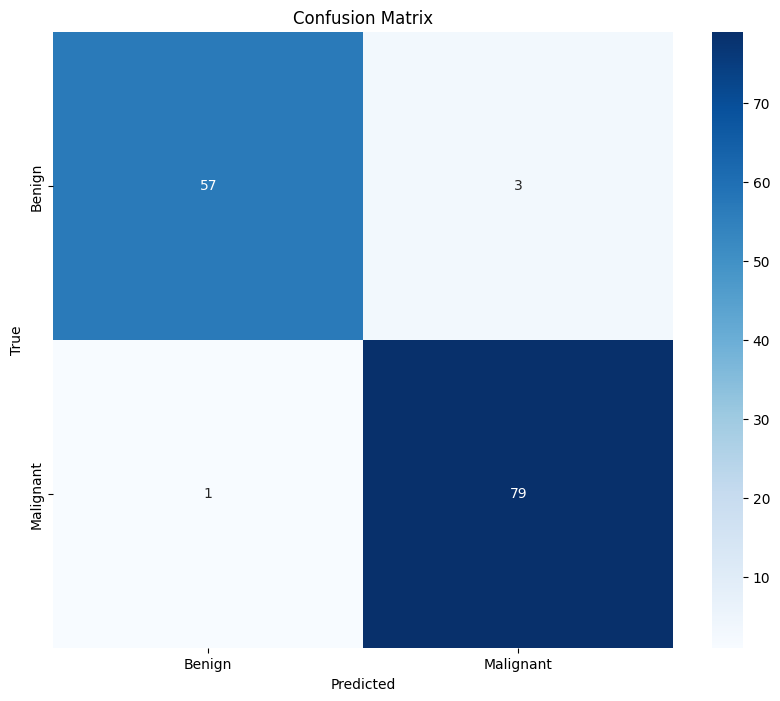

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(val_labels, val_preds)
cm_labels = ['Benign', 'Malignant']  # Update with your actual class names if needed

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate classification report
report = classification_report(val_labels, val_preds, target_names=cm_labels)
print(report)
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

import pandas as pd
metrics_df = pd.DataFrame({
    'Class': cm_labels,
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN
})

              precision    recall  f1-score   support

      Benign       0.98      0.95      0.97        60
   Malignant       0.96      0.99      0.98        80

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



In [ ]:
print(metrics_df)

       Class  TP  TN  FP  FN
0     Benign  57  79   1   3
1  Malignant  79  57   3   1


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
import numpy as np
# ... (rest of the code)

model = models.load_model('/content/drive/MyDrive/DatasetModel/trainedModel.h5')

def preprocess_image(image_path):
    # Load the image using load_img from tensorflow.keras.utils
    img = load_img(image_path, target_size=(150, 150))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


image_path = '/content/drive/MyDrive/Dataset/1 1 BreakHis_Data-200x/val/benign/SOB_B_A-14-22549AB-200-015.png'
image = preprocess_image(image_path)

# Predict the class
predictions = model.predict(image)
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class: {predicted_class}")
if predicted_class == 0:
    print(f"Benign")
else:
    print(f"Malignant")

1/1 [==============================] - 1s 1s/step
Predicted Class: 0
Benign


In [ ]:
!pip install pi

In [ ]:
!pip install lime
import lime
from lime import lime_image  # Import the lime_image module
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a0c49085c23d1f49360b635339670f881615ffb2374d9978b71e18797b3589aa
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


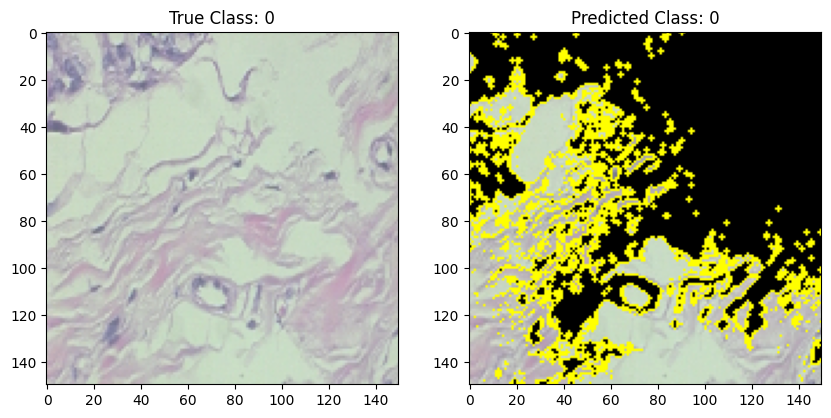

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array  # Make sure to import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
import numpy as np
# ... (rest of the code)

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define a prediction function for LIME
def predict_fn(images):
    images = np.array([preprocess_input(img_to_array(image)) for image in images]) #img_to_array should be accessible here as well.
    return model.predict(images)

# Generate LIME explanation
explanation = explainer.explain_instance(
    img_to_array(load_img(image_path, target_size=(150, 150))), # img_to_array call
    predict_fn,
    top_labels=4,
    num_samples=1000,
    batch_size=10
)


temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=True
)
img_boundry = mark_boundaries(temp / 255.0, mask)
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(load_img(image_path, target_size=(150, 150)))
plt.title(f"True Class: {predicted_class}")

# LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(img_boundry)
plt.title(f"Predicted Class: {predicted_class}")

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
import numpy as np
# ... (rest of the code)

model = models.load_model('/content/drive/MyDrive/DatasetModel/trainedModel.h5')

def preprocess_image(image_path):
    # Load the image using load_img from tensorflow.keras.utils
    img = load_img(image_path, target_size=(150, 150))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


image_path = '/content/drive/MyDrive/Dataset/1 1 BreakHis_Data-200x/val/malignant/SOB_M_DC-14-11520-200-016.png'
image = preprocess_image(image_path)

# Predict the class
predictions = model.predict(image)
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class: {predicted_class}")
if predicted_class == 0:
    print(f"Benign")
else:
    print(f"Malignant")

1/1 [==============================] - 1s 1s/step
Predicted Class: 1
Malignant


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 131ms/step


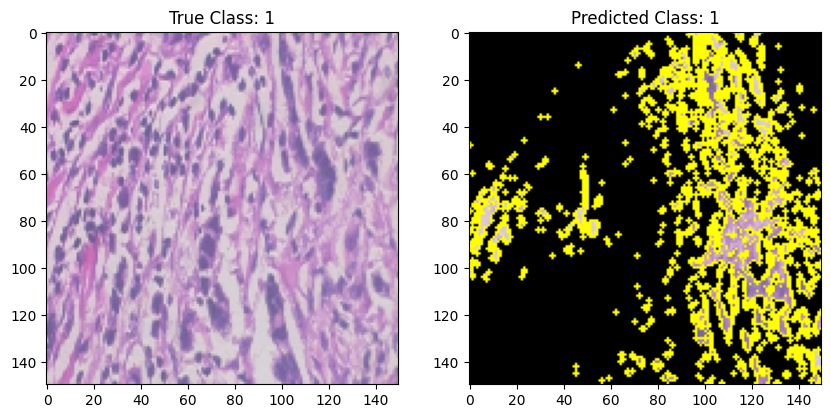

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array  # Make sure to import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
import numpy as np
# ... (rest of the code)

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define a prediction function for LIME
def predict_fn(images):
    images = np.array([preprocess_input(img_to_array(image)) for image in images]) #img_to_array should be accessible here as well.
    return model.predict(images)

# Generate LIME explanation
explanation = explainer.explain_instance(
    img_to_array(load_img(image_path, target_size=(150, 150))), # img_to_array call
    predict_fn,
    top_labels=4,
    num_samples=1000,
    batch_size=10
)


temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=True
)
img_boundry = mark_boundaries(temp / 255.0, mask)
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(load_img(image_path, target_size=(150, 150)))
plt.title(f"True Class: {predicted_class}")

# LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(img_boundry)
plt.title(f"Predicted Class: {predicted_class}")

plt.show()